# Imports

In [195]:
import pandas as pd     
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

# Processing Data

Here I will tokenize and lemmatize the cleaned dataframe.

In [43]:
clean = pd.read_csv('./data/clean_subreddit_data.csv')

In [44]:
clean['tokenized_sent'] = clean.apply(lambda row: word_tokenize(row['fulltext']), axis=1)

In [45]:
stop_words = set(stopwords.words('english'))
clean['stopwords_removed'] = clean['tokenized_sent'].apply(lambda x: [word for word in x if word not in stop_words])
clean.head()

,selftext,subreddit,title,fulltext,nosleep,tokenized_sent,stopwords_removed
0,[Part 1](https://www.reddit.com/r/nosleep/comm...,nosleep,My memories may soon kill me. (Part 2),My memories may soon kill me. (Part 2) [Part 1...,1,"[My, memories, may, soon, kill, me, ., (, Part...","[My, memories, may, soon, kill, ., (, Part, 2,..."
1,Suki was assigned her maternal spirit at bi...,nosleep,Sometimes The Devil Wins,Sometimes The Devil Wins Suki was assigned ...,1,"[Sometimes, The, Devil, Wins, Suki, was, assig...","[Sometimes, The, Devil, Wins, Suki, assigned, ..."
2,I want to preface this by saying that I have n...,nosleep,"The woman that haunts me, day and night","The woman that haunts me, day and night I want...",1,"[The, woman, that, haunts, me, ,, day, and, ni...","[The, woman, haunts, ,, day, night, I, want, p..."
3,When the kidnapper made me guess where he kept...,nosleep,Good Night :),Good Night :) When the kidnapper made me guess...,1,"[Good, Night, :, ), When, the, kidnapper, made...","[Good, Night, :, ), When, kidnapper, made, gue..."
4,It was memorial weekend and in my home state o...,nosleep,Camping on the Run,Camping on the Run It was memorial weekend and...,1,"[Camping, on, the, Run, It, was, memorial, wee...","[Camping, Run, It, memorial, weekend, home, st..."


In [30]:
lemmatizer = WordNetLemmatizer()

In [46]:
# labeling words with NLTK labels

clean['tags'] = clean['stopwords_removed'].apply(nltk.tag.pos_tag)
clean.head()

,selftext,subreddit,title,fulltext,nosleep,tokenized_sent,stopwords_removed,tags
0,[Part 1](https://www.reddit.com/r/nosleep/comm...,nosleep,My memories may soon kill me. (Part 2),My memories may soon kill me. (Part 2) [Part 1...,1,"[My, memories, may, soon, kill, me, ., (, Part...","[My, memories, may, soon, kill, ., (, Part, 2,...","[(My, PRP$), (memories, NNS), (may, MD), (soon..."
1,Suki was assigned her maternal spirit at bi...,nosleep,Sometimes The Devil Wins,Sometimes The Devil Wins Suki was assigned ...,1,"[Sometimes, The, Devil, Wins, Suki, was, assig...","[Sometimes, The, Devil, Wins, Suki, assigned, ...","[(Sometimes, RB), (The, DT), (Devil, NNP), (Wi..."
2,I want to preface this by saying that I have n...,nosleep,"The woman that haunts me, day and night","The woman that haunts me, day and night I want...",1,"[The, woman, that, haunts, me, ,, day, and, ni...","[The, woman, haunts, ,, day, night, I, want, p...","[(The, DT), (woman, NN), (haunts, NNS), (,, ,)..."
3,When the kidnapper made me guess where he kept...,nosleep,Good Night :),Good Night :) When the kidnapper made me guess...,1,"[Good, Night, :, ), When, the, kidnapper, made...","[Good, Night, :, ), When, kidnapper, made, gue...","[(Good, JJ), (Night, NNP), (:, :), (), )), (Wh..."
4,It was memorial weekend and in my home state o...,nosleep,Camping on the Run,Camping on the Run It was memorial weekend and...,1,"[Camping, on, the, Run, It, was, memorial, wee...","[Camping, Run, It, memorial, weekend, home, st...","[(Camping, VBG), (Run, NNP), (It, PRP), (memor..."


In [51]:
# https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28
# changing NLTK labels to English words (adjective, verb, noun, adverb)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
clean['type'] = clean['tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
clean.head()

,selftext,subreddit,title,fulltext,nosleep,tokenized_sent,stopwords_removed,tags,type
0,[Part 1](https://www.reddit.com/r/nosleep/comm...,nosleep,My memories may soon kill me. (Part 2),My memories may soon kill me. (Part 2) [Part 1...,1,"[My, memories, may, soon, kill, me, ., (, Part...","[My, memories, may, soon, kill, ., (, Part, 2,...","[(My, PRP$), (memories, NNS), (may, MD), (soon...","[(My, n), (memories, n), (may, n), (soon, r), ..."
1,Suki was assigned her maternal spirit at bi...,nosleep,Sometimes The Devil Wins,Sometimes The Devil Wins Suki was assigned ...,1,"[Sometimes, The, Devil, Wins, Suki, was, assig...","[Sometimes, The, Devil, Wins, Suki, assigned, ...","[(Sometimes, RB), (The, DT), (Devil, NNP), (Wi...","[(Sometimes, r), (The, n), (Devil, n), (Wins, ..."
2,I want to preface this by saying that I have n...,nosleep,"The woman that haunts me, day and night","The woman that haunts me, day and night I want...",1,"[The, woman, that, haunts, me, ,, day, and, ni...","[The, woman, haunts, ,, day, night, I, want, p...","[(The, DT), (woman, NN), (haunts, NNS), (,, ,)...","[(The, n), (woman, n), (haunts, n), (,, n), (d..."
3,When the kidnapper made me guess where he kept...,nosleep,Good Night :),Good Night :) When the kidnapper made me guess...,1,"[Good, Night, :, ), When, the, kidnapper, made...","[Good, Night, :, ), When, kidnapper, made, gue...","[(Good, JJ), (Night, NNP), (:, :), (), )), (Wh...","[(Good, a), (Night, n), (:, n), (), n), (When,..."
4,It was memorial weekend and in my home state o...,nosleep,Camping on the Run,Camping on the Run It was memorial weekend and...,1,"[Camping, on, the, Run, It, was, memorial, wee...","[Camping, Run, It, memorial, weekend, home, st...","[(Camping, VBG), (Run, NNP), (It, PRP), (memor...","[(Camping, v), (Run, n), (It, n), (memorial, a..."


In [78]:
clean['lemmatized'] = clean['type'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
clean.head()

,selftext,subreddit,title,fulltext,nosleep,tokenized_sent,stopwords_removed,tags,type,lemmatized
0,[Part 1](https://www.reddit.com/r/nosleep/comm...,nosleep,My memories may soon kill me. (Part 2),Creepy customer I am a 18 year old cashier at ...,1,"[My, memories, may, soon, kill, me, ., (, Part...","[My, memories, may, soon, kill, ., (, Part, 2,...","[(My, PRP$), (memories, NNS), (may, MD), (soon...","[(My, n), (memories, n), (may, n), (soon, r), ...","[My, memory, may, soon, kill, ., (, Part, 2, )..."
1,Suki was assigned her maternal spirit at bi...,nosleep,Sometimes The Devil Wins,Creepy customer I am a 18 year old cashier at ...,1,"[Sometimes, The, Devil, Wins, Suki, was, assig...","[Sometimes, The, Devil, Wins, Suki, assigned, ...","[(Sometimes, RB), (The, DT), (Devil, NNP), (Wi...","[(Sometimes, r), (The, n), (Devil, n), (Wins, ...","[Sometimes, The, Devil, Wins, Suki, assign, ma..."
2,I want to preface this by saying that I have n...,nosleep,"The woman that haunts me, day and night",Creepy customer I am a 18 year old cashier at ...,1,"[The, woman, that, haunts, me, ,, day, and, ni...","[The, woman, haunts, ,, day, night, I, want, p...","[(The, DT), (woman, NN), (haunts, NNS), (,, ,)...","[(The, n), (woman, n), (haunts, n), (,, n), (d...","[The, woman, haunt, ,, day, night, I, want, pr..."
3,When the kidnapper made me guess where he kept...,nosleep,Good Night :),Creepy customer I am a 18 year old cashier at ...,1,"[Good, Night, :, ), When, the, kidnapper, made...","[Good, Night, :, ), When, kidnapper, made, gue...","[(Good, JJ), (Night, NNP), (:, :), (), )), (Wh...","[(Good, a), (Night, n), (:, n), (), n), (When,...","[Good, Night, :, ), When, kidnapper, make, gue..."
4,It was memorial weekend and in my home state o...,nosleep,Camping on the Run,Creepy customer I am a 18 year old cashier at ...,1,"[Camping, on, the, Run, It, was, memorial, wee...","[Camping, Run, It, memorial, weekend, home, st...","[(Camping, VBG), (Run, NNP), (It, PRP), (memor...","[(Camping, v), (Run, n), (It, n), (memorial, a...","[Camping, Run, It, memorial, weekend, home, st..."


# Sentiment Analysis

In [55]:
analyzer = SentimentIntensityAnalyzer()

In [72]:
corpus = list(clean['fulltext'])

In [75]:
sentiment = []    

for post in corpus:
    scores = analyzer.polarity_scores(post)
    clean['fulltext'] = post
    sentiment.append(scores)

dfs = pd.DataFrame(sentiment)
dfs.head()

,neg,neu,pos,compound
0,0.129,0.811,0.060,-0.9999
1,0.169,0.742,0.089,-0.9996
2,0.089,0.841,0.071,-0.9812
3,0.047,0.796,0.157,0.6996
4,0.125,0.802,0.073,-0.9967


In [139]:
clean['comp_sent'] = dfs['compound']
clean.head()

,selftext,subreddit,title,fulltext,nosleep,tokenized_sent,stopwords_removed,tags,type,lemmatized,comp_sent
0,[Part 1](https://www.reddit.com/r/nosleep/comm...,nosleep,My memories may soon kill me. (Part 2),Creepy customer I am a 18 year old cashier at ...,1,"[My, memories, may, soon, kill, me, ., (, Part...","[My, memories, may, soon, kill, ., (, Part, 2,...","[(My, PRP$), (memories, NNS), (may, MD), (soon...","[(My, n), (memories, n), (may, n), (soon, r), ...","[My, memory, may, soon, kill, ., (, Part, 2, )...",-0.9999
1,Suki was assigned her maternal spirit at bi...,nosleep,Sometimes The Devil Wins,Creepy customer I am a 18 year old cashier at ...,1,"[Sometimes, The, Devil, Wins, Suki, was, assig...","[Sometimes, The, Devil, Wins, Suki, assigned, ...","[(Sometimes, RB), (The, DT), (Devil, NNP), (Wi...","[(Sometimes, r), (The, n), (Devil, n), (Wins, ...","[Sometimes, The, Devil, Wins, Suki, assign, ma...",-0.9996
2,I want to preface this by saying that I have n...,nosleep,"The woman that haunts me, day and night",Creepy customer I am a 18 year old cashier at ...,1,"[The, woman, that, haunts, me, ,, day, and, ni...","[The, woman, haunts, ,, day, night, I, want, p...","[(The, DT), (woman, NN), (haunts, NNS), (,, ,)...","[(The, n), (woman, n), (haunts, n), (,, n), (d...","[The, woman, haunt, ,, day, night, I, want, pr...",-0.9812
3,When the kidnapper made me guess where he kept...,nosleep,Good Night :),Creepy customer I am a 18 year old cashier at ...,1,"[Good, Night, :, ), When, the, kidnapper, made...","[Good, Night, :, ), When, kidnapper, made, gue...","[(Good, JJ), (Night, NNP), (:, :), (), )), (Wh...","[(Good, a), (Night, n), (:, n), (), n), (When,...","[Good, Night, :, ), When, kidnapper, make, gue...",0.6996
4,It was memorial weekend and in my home state o...,nosleep,Camping on the Run,Creepy customer I am a 18 year old cashier at ...,1,"[Camping, on, the, Run, It, was, memorial, wee...","[Camping, Run, It, memorial, weekend, home, st...","[(Camping, VBG), (Run, NNP), (It, PRP), (memor...","[(Camping, v), (Run, n), (It, n), (memorial, a...","[Camping, Run, It, memorial, weekend, home, st...",-0.9967


In [148]:
df_nosleep = clean[clean['nosleep'] == 1]
sleepsentcount = pd.DataFrame(df_nosleep['comp_sent'].value_counts())

In [149]:
df_letsnot = clean[clean['nosleep'] == 0]
letnotsentcount = pd.DataFrame(df_letsnot['comp_sent'].value_counts())

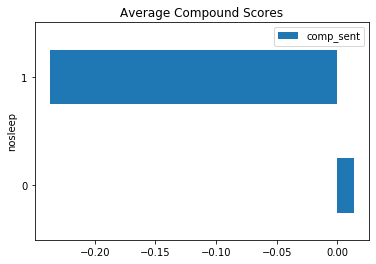

In [150]:
clean.groupby('nosleep').mean()[['comp_sent']].plot(kind='barh')
plt.title('Average Compound Scores');

On average, posts from r/nosleep appear to have very strong sentiments tied to them and posts from r/LetsNotMeet are very close to neutral. This could be due to the fact that fictional stories rely on adjectives and adverbs to paint pictures for the reader. Real-life events can usually be told with enough detail for it to seem believable without drawing on too many evocative words. This theory could potentially be applied in other situations when trying to assess how real a story is.

# Setting Up Variables

In [62]:
X = clean['fulltext']
y = clean['nosleep']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

# Baseline Statistics

In [91]:
y.value_counts(normalize=True)

1    0.642988
0    0.357012
Name: nosleep, dtype: float64

This is the accuracy score that our models should aim to beat.

# CountVectorizer

Vectorizing the columns with words so they can be used in model training and analysis.

In [92]:
cvec = CountVectorizer(stop_words='english', max_features=2_000)

In [93]:
Xc_train = cvec.fit_transform(X_train)

In [94]:
Xc_test = cvec.transform(X_test)

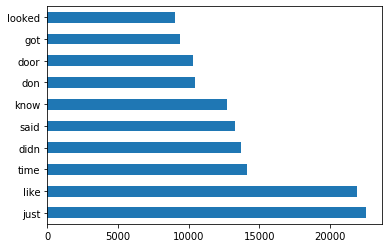

In [95]:
# words that occur commonly across the two, without stop words

Xc_train_df = pd.DataFrame(Xc_train.todense(), columns=cvec.get_feature_names())
Xc_train_df.head()
Xc_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

In [105]:
df_X_train = pd.DataFrame(Xc_train.todense(), columns = cvec.get_feature_names())

In [106]:
df_X_test = pd.DataFrame(Xc_test.todense(), columns = cvec.get_feature_names())

In [107]:
df_X_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
df_X_test.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)

# TF-IDF

Another form of vectorization, this time focusing on the frequency of the words.

In [128]:
tvec = TfidfVectorizer()

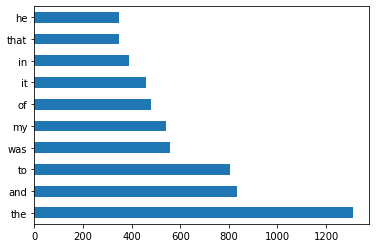

In [171]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), columns=tvec.get_feature_names())
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

# Multinomial Naive-Bayes with Pipeline and GridSearch

In [172]:
pipe_tvec = Pipeline([('tvec', TfidfVectorizer()), ('nb', MultinomialNB())])

In [173]:
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [174]:
gs = GridSearchCV(pipe_tvec, pipe_tvec_params, cv = 5)

In [175]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [176]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9310115350488021, 0.9214903526280772)

In [178]:
tvec_preds = gs.predict(X_test)
tn_gs, fp_gs, fn_gs, tp_gs = confusion_matrix(y_test, tvec_preds).ravel()

In [179]:
accuracy_score(y_test, tvec_preds)

0.9214903526280772

In [199]:
f1_score(y_test, tvec_preds)

0.9386694386694386

Right off the bat, this model looks great. Only overfit by 1%, and the scores are in the low 90s. While we are focusing on the accuracy because it is intuitively interpretable, the F1 scores are a very balanced metric to be aware of that combines two metrics that are not always useful on their own (precision and recall). Our F1 score here shows that this model correctly predicted almost 94% of the classifications.

# Random Forest

In [110]:
rfc = RandomForestClassifier()

In [111]:
rfc.fit(Xc_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [112]:
rfc.score(Xc_train, y_train), rfc.score(Xc_test, y_test)

(0.9971162377994676, 0.9028609447771124)

In [183]:
rfc_preds = rfc.predict(Xc_test)

In [184]:
accuracy_score(y_test, rfc_preds)

0.9028609447771124

In [200]:
f1_score(y_test, rfc_preds)

0.9268537074148296

While this model also did well, it is very overfit, so it is second to MNB.

# Extra Trees

In [122]:
et = ExtraTreesClassifier()

In [123]:
et.fit(Xc_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [124]:
et.score(Xc_train, y_train), et.score(Xc_test, y_test)

(0.9971162377994676, 0.9001996007984032)

In [125]:
f2 = {'Column Name':df_X_train.columns,'Feature Importance':et.feature_importances_}
et_fi = pd.DataFrame(f2)

et_fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
1106,meet,0.014110
777,guy,0.010560
395,creepy,0.009269
590,eyes,0.008662
173,blood,0.006901
179,body,0.006504
438,deep,0.006361
1020,like,0.006240
968,know,0.004885
1016,life,0.004786


In [185]:
et_preds = et.predict(Xc_test)
tn_et, fp_et, fn_et, tp_et = confusion_matrix(y_test, et_preds).ravel()

In [186]:
accuracy_score(y_test, et_preds)

0.9001996007984032

In [201]:
f1_score(y_test, et_preds)

0.9257425742574258

This model had scores similar to the Random Forest Classifier across the board, but because the training score was 2.6% higher, the model is even more overfit.

# KNN

In [191]:
knn = KNeighborsClassifier()

In [192]:
knn.fit(Xc_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [193]:
knn.score(Xc_train, y_train), knn.score(Xc_test, y_test)

(0.7566548358473825, 0.6660013306719893)

In [196]:
cross_val_score(knn, Xc_train, y_train).mean()

0.6508469279022323

In [197]:
knn_preds = knn.predict(Xc_test)

In [198]:
accuracy_score(y_test, knn_preds)

0.6660013306719893

In [202]:
f1_score(y_test, knn_preds)

0.6842767295597484

This model performed the worst of all of them; it was barely better than the baseline. Interesting to note, though, that it has less variance than the Extra Trees Classifier. It's not much better in terms of overfitting, but it is slightly better.

# Concluding Analysis

Of the four models, three of them were able to make accurate predictions at a significantly higher rate than the baseline. MNB, RFC and ETC all had scores into the 90s, but only MNB had consistent scores, making it the ideal model for the situation. Adjusting the parameters of the MNB model might be able to bring the scores up by a few percentage points, but it is highly unlikely it can ever be perfect.

It is important to realize that the error within the model is significant. It means that a number of posts are not correctly labeled as fake when they are, or real information is being labeled fake. This kind of mislabeling can be detrimental in certain situations, so it is important to have a kind of safety net to catch the posts that do slip through the cracks. This safety net, generally, is human intervention. On Reddit, moderators can sift through posts and other users can report them. While this feature can and is misused, it is the best bet to stop fake information from being displayed as real.